# Lab 3: CNN Visualization

Group Members:

- Parker Brown

- Suma Chackola

- Chris Peters

- Oliver Raney



**The execution of this lab was performed collaboratively across 4 computers. Therefore, while the individual cells are not all shown with the direct execution results, the code presented in those cells was utilized to produce the results in this notebook.**


In this lab we will find and analyze a circuit in a common neural network.  A reference figure is also shown to help clarify the process of finding and analyzing deep circuits.

The terminology used in this lab is as follows: 
- (1) a filter refers to the entire tensor that convolves with an input across all channels (i.e., a multi-channel filter like a 3x3x64 tensor)
- (2) a single channel filter refers to one channel of the aforementioned filter (e.g., a 3x3x1 convolution kernel)
- (3) and activation refers to the input or output of the filter depending on context (i.e., input activations for a filter are the inputs from a previous layer, output activations are all the filter outputs from a convolutional layer)
- (4) an input can refer to all input channels or a single input channel depending on the context (entire filter or single channel filter, respectively). 

A diagram is provided for clarity and this was covered in detail in the class lecture. 

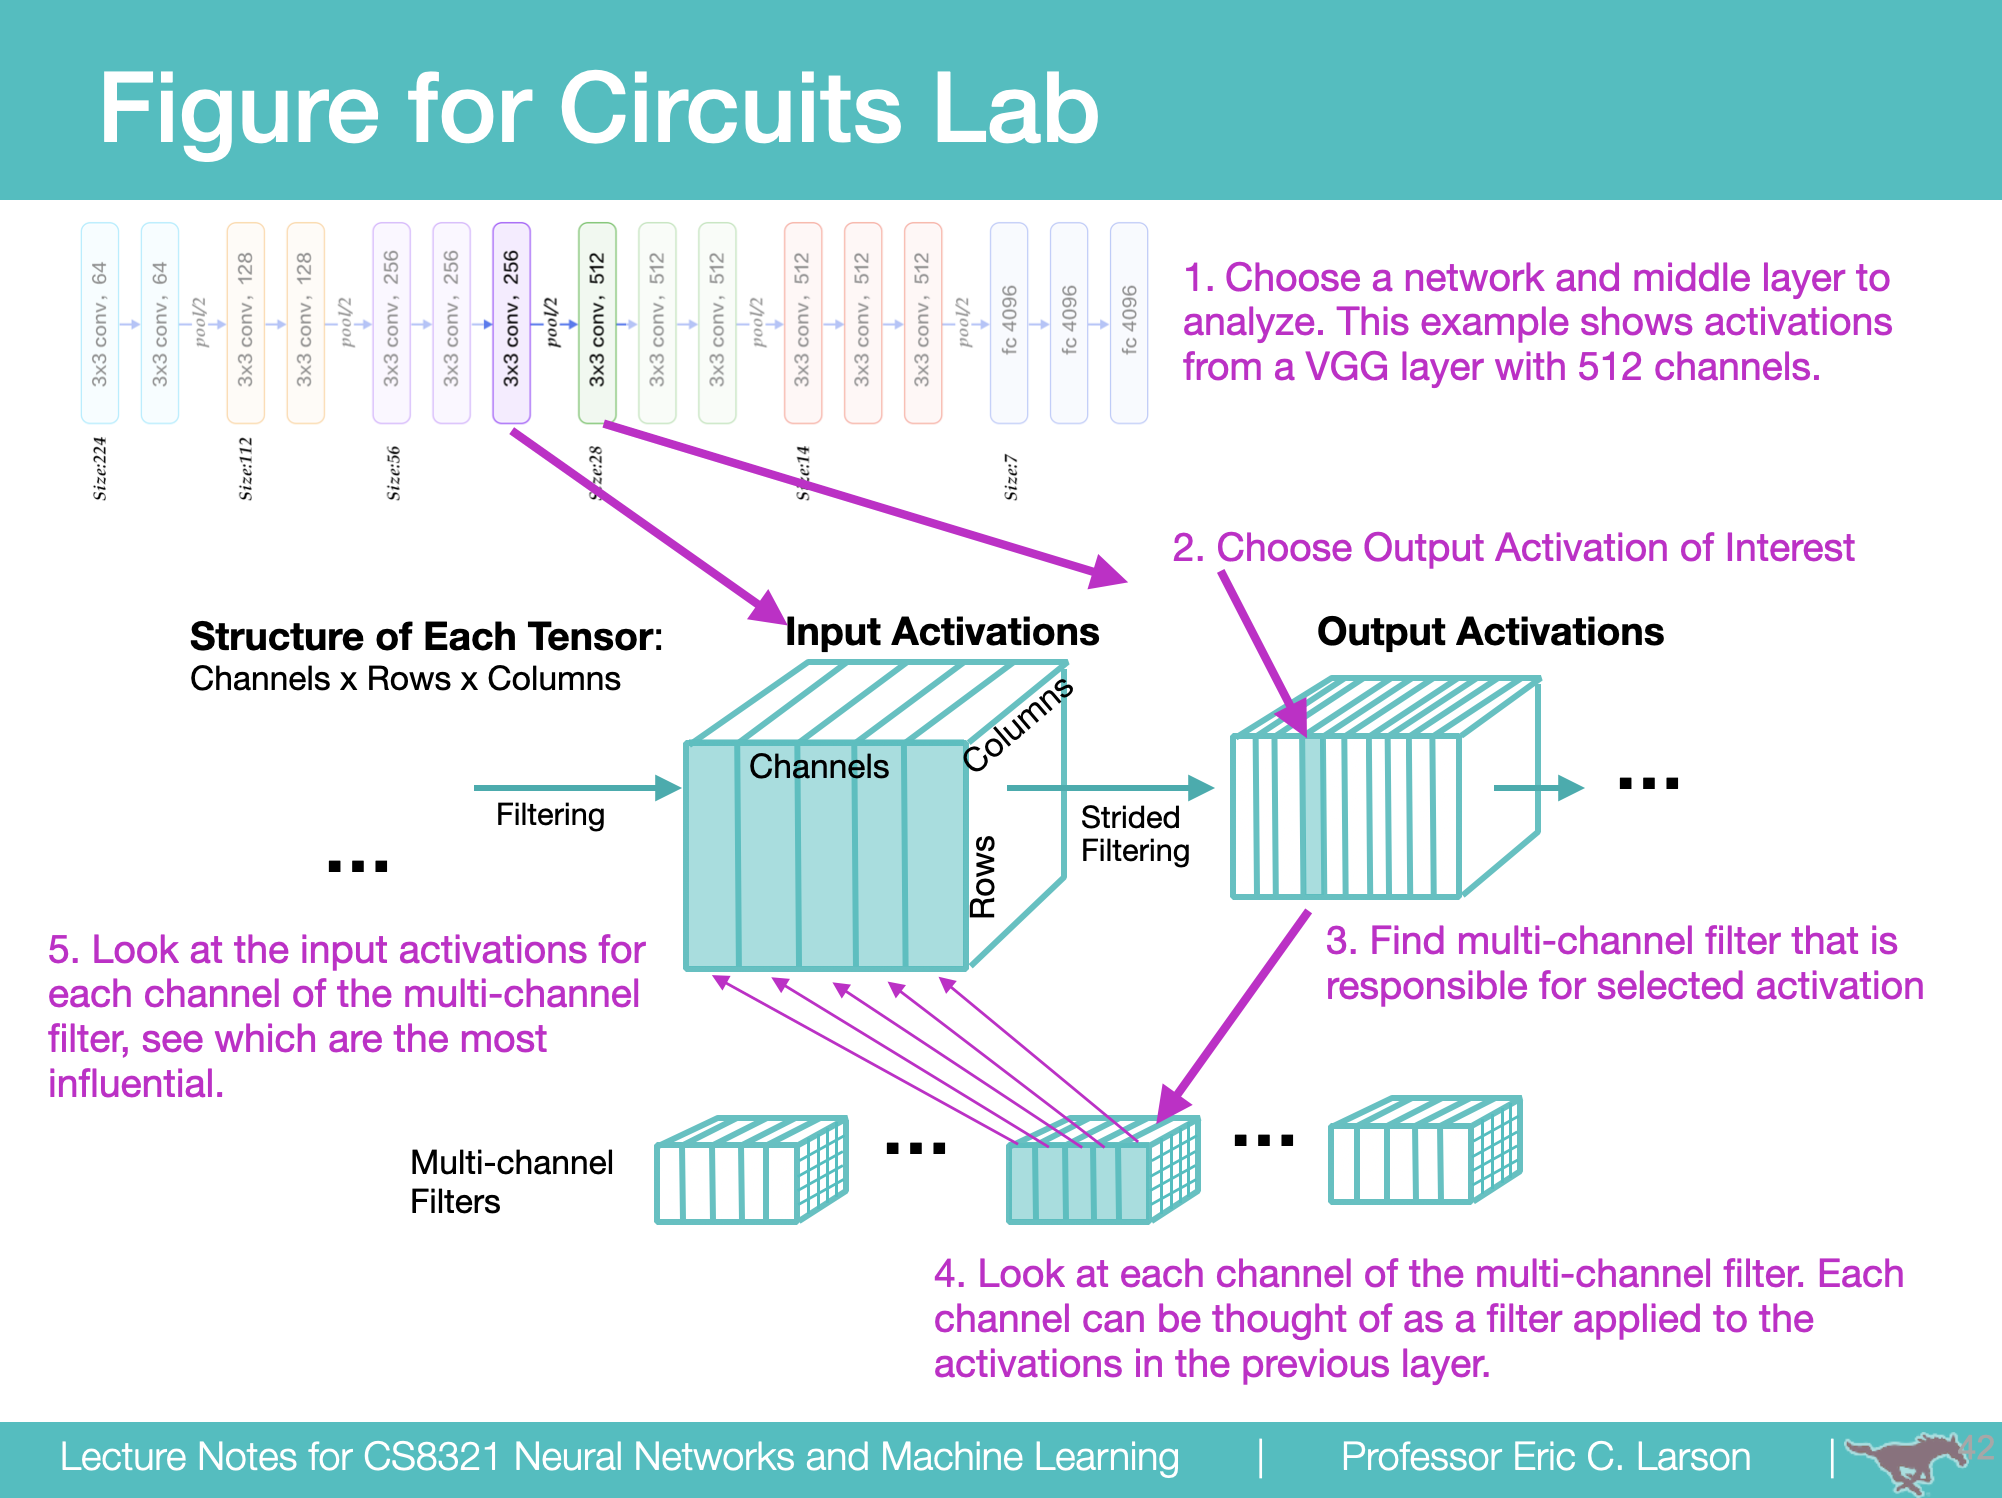

In [1]:
from IPython.display import Image
Image(filename='CircuitsFigure.png') 

<a id="top"></a>
## Contents
* <a href="#P1">1.0 Introduction & CNN Overview</a>
* <a href="#P2">2.0 Circuit Selection & Extraction Hypothesis </a>
* <a href="#P3">3.0 Circuit Analysis </a>
* <a href="#P4">4.0 Image Gradient Visualization </a>
_______________________________


<a href="#top">Back to Top</a>
<a id="P1"></a>
## 1.0 Introduction & CNN Overview
[3 points]
#### In groups, you should select a convolutional neural network model that has been pre-trained on a large dataset (preferably, ImageNet). These already trained models are readily available online through many mechanisms, including the keras.application package (Inception, Xception, VGG etc.) 

https://keras.io/api/applications/

#### - It is recommended to select a model with somewhat simple structure, like VGG. This can help to simplify how to extract specific filters and inputs to filters later on.

#### - Explain the model you chose and why.  Classify a few images with pre-trained network to verify that it is working properly.

<span style="color:blue">
    Notes:
- No training involved: Use VGG and play with it!
    
- VGG16 has layers and structure that makes sense for this lab

- Classify dogs, cats, etc to verify
</span>

<a href="#top">Back to Top</a>
<a id="P2"></a>
## 2.0 Circuit Selection & Extraction Hypothesis
[4 points]
#### Select a multi-channel filter (i.e., a feature) in a layer in which to analyze as part of a circuit. This should be a multi-channel filter in a "mid-level" portion of the network (that is, there are convolutional layers before and after this chosen layer). You might find using OpenAI microscope a helpful tool for selecting a filter to analyze without writing too much code: 
https://microscope.openai.com/models/

#### - Using image gradient techniques, find an input image that maximally excites this chosen multi-channel filter. General techniques are available from class: 

https://github.com/8000net/LectureNotesMaster/blob/master/04%20LectureVisualizingConvnets.ipynb
#### - Also send images of varying class (i.e., from ImageNet) through the network and track which classes of images most excite your chosen filter. 
#### - Give a hypothesis for what this multi-channel filter might be extracting. That is, what do you think its function is in the network? Give reasoning for your hypothesis. 
#### - If using code from another source or a LLM, you should heavily document the code so that I can grade your understanding of the code used. 

<span style="color:blue">
    Notes:
- Will need to visualize a bunch of layers. OR Go to Open AI microscope to select filter & analyze it
    
- Regarding Image Gradient techniques: Look at code from notebook that updates the input image to maximally excite the filter. Do not take a bunch of images and see which has biggest output. Use input gradient techniques

- Regarding sending images of varying classes:
    - Also send images of varying classes through network & track which classes are most excitatory to chosen filter. 
    - Take random images (2000 or so), run them through VGG for the particular filter you've chosen, save off the output activations, and sum them up. See which has the biggest sum. 
</span>

In [2]:
# watermark the notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import sys
import tensorflow.keras
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpus = tf.config.list_physical_devices('GPU')
print("GPU Resources Available:\n\t",gpus)

# getting rid of the warning messages about optimizer graph
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)


Python Platform: Windows-10-10.0.22631-SP0
Tensor Flow Version: 2.10.1
Keras Version: 2.10.0

Python 3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
GPU Resources Available:
	 []


In [5]:

# We preprocess the image into a 4D tensor
#from keras.preprocessing import image
import numpy as np
import requests
from io import BytesIO
from PIL import Image

def load_image_as_array(url, size=(150, 150)):
    response = requests.get(url) # download
    img = Image.open(BytesIO(response.content)) # open
    img = img.resize(size) # resize with PIL
    return np.array(img).astype(float) # return as numpy float array

def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)
        
    return new_img.astype('uint8')
    

import matplotlib.pyplot as plt

In [10]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import models

# Load the pre-trained VGG19 model
model = VGG19(weights='imagenet', include_top=False, input_tensor=None)



In [7]:
#  let's look at the model for VGG
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

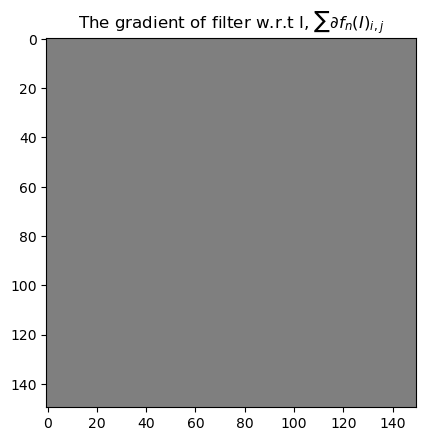

In [20]:
# set VGG to be frozen
for layer in model.layers:
    layer.trainable = False

# Selecting a layer and channel to visualize
layer_name = 'block5_conv2'
filter_index = 0
 
# Isolate the output of interest and create new model
layer_output = model.get_layer(layer_name).output
new_model = models.Model(inputs=model.input, outputs=layer_output)
# now "new_model" has the output we desire to maximize

# create a variable that we can access and update in computation graph
I = tf.Variable(np.zeros((1, 150, 150, 3),dtype='double'), name='image_var', dtype = 'float64')

# now use gradient tape to get the gradients (watching only the variable v)
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(I) # watch
    model_vals = new_model(preprocess_input(I)) # get output
    filter_output_to_maximize = tf.reduce_mean(model_vals[:, :, :, filter_index]) # define what we want to maximize
    
grad_fn = tape.gradient(filter_output_to_maximize, I) # get gradients that influence loss w.r.t. v
grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm (better stability)

# now show the gradient, same size as input image
plt.imshow(prepare_image_for_display( grad_fn.numpy(), norm_type='std'))
plt.title('The gradient of filter w.r.t I, $ \sum\partial f_n(I)_{i,j} $ ')
plt.show()

In [21]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = preprocess_input(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(40):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            filter_output = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(filter_output, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

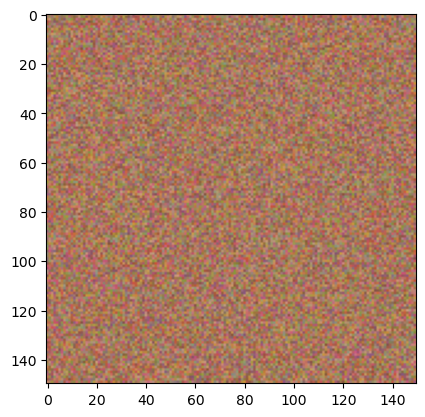

In [22]:
plt.imshow(generate_pattern('block5_conv1', 6))
plt.show()

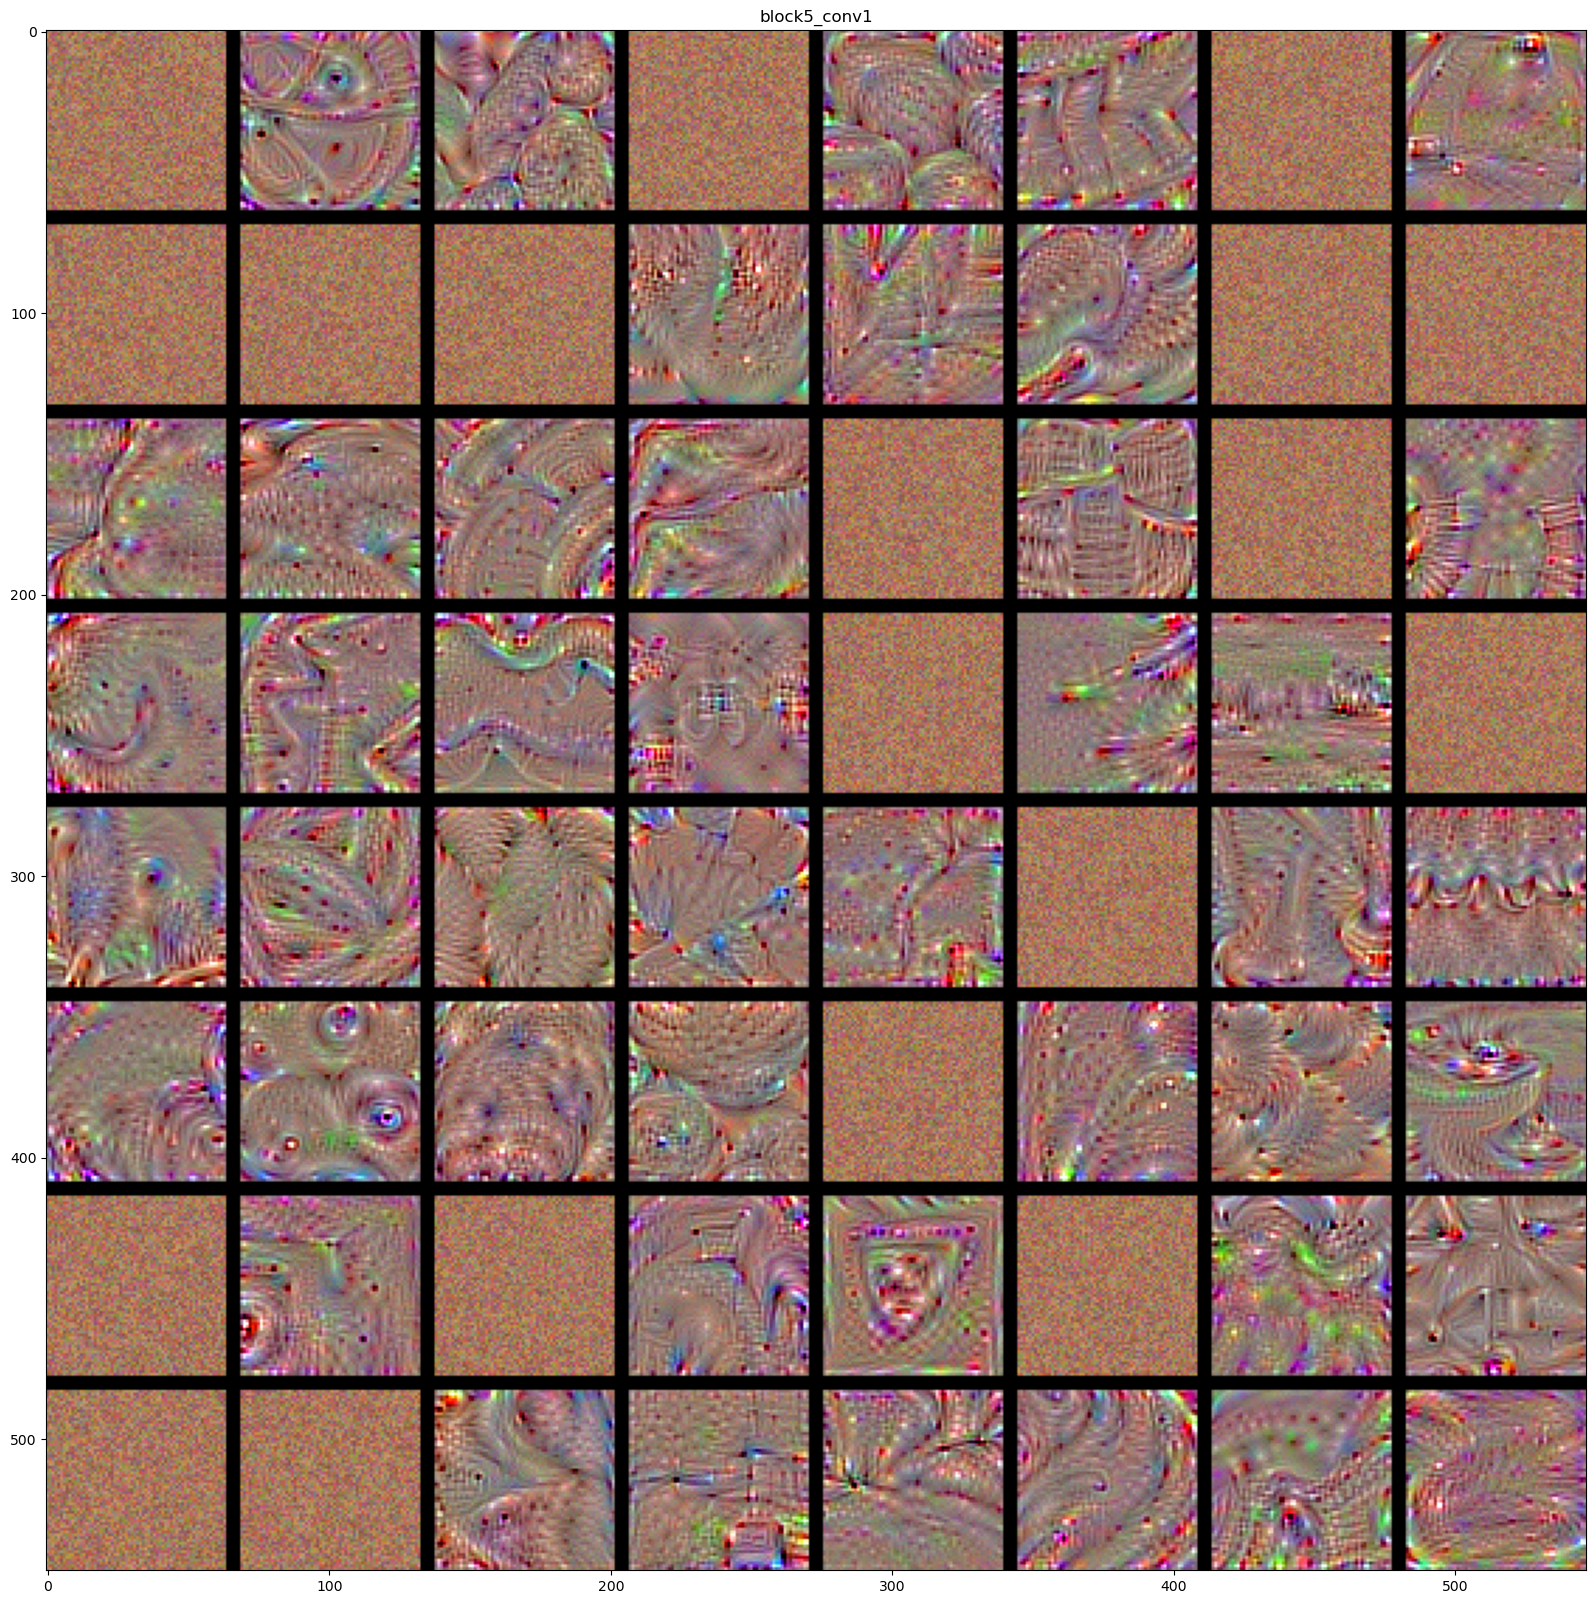

In [23]:
for layer_name in ['block5_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3)).astype('uint8')

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.title(layer_name)
    plt.show()

<a href="#top">Back to Top</a>
<a id="P3"></a>
## 3.0 Circuit Analysis
[4 points]
#### Analyze each channel of the multi-channel filter to better understand how this might form a circuit (i.e., the weights of the filter). That is, visualize the convolutional filter (one channel at a time) between the input activations and the current activation to understand which inputs make up a circuit. You should avoid filter channels that are mostly "zero" coefficients. These are not influential for the circuit. One method of doing this is given below:

#### - Extract the filter coefficients for each input activation to that multi-channel filter. Note: If the multi-channel filter is 5x5 with an input channel size of 64, then this extraction will result in 64 different single channel filters, each of size 5x5. 
#### - Keep the top ten sets of inputs with the "strongest" weights. For now, you can use the L2 norm of each input filter as a measure of strength. Visualize these top ten filters. 
#### - For these ten strongest input filters, categorize each as "mostly inhibitory" or "mostly excitatory." That is, does each filter consist of mostly negative or mostly positive coefficients?  



<span style="color:blue">
    Notes:
    
- Regarding Extract the filter coefficients
    - Look at all of the input activations for this particular output activation and visualize the input activations & filter channels that most influence filter output. 
    - How? One way: extract the filter coeffs for every channel of your multi-channel filter. For 64 filters: you'll have 64 separate 3x3 filters

- Regarding top 10:
    - Keep top 10 with strongest weights. How? Take sum or max of all by 3x3 filters.
    
- Regarding "mostly inhibibotry/excitatory": Look at filter value to determine their categorization
</span>

<a href="#top">Back to Top</a>
<a id="P4"></a>
## 4.0 Image Gradient Visualization
[4 points]
#### For each of the ten chosen single channels of the filter, use image gradient techniques to visualize what each of these filters is most excited by (that is, what image maximally excites each of these filters?). This is a similar analysis to the first step in this rubric, but now isolating the activations the layer preceding your chosen filter. This should only be completed for the ten most influential filters.  

#### - Use these visualizations, along with the circuit weights you just discovered to try and explain how this particular circuit works. An example of this visualization style can be seen here:

https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/mixed3b_379.html
#### - Try to define the properties of this circuit using vocabulary from https://distill.pub/2020/circuits/zoom-in/Links to an external site. (such as determining if this is polysemantic, pose-invariant, etc.)  

#### - Relate your visualizations back to your original hypothesis about what this filter is extracting. Does it support or refute your hypothesis? Why? 

<span style="color:blue">
    Notes:
    
- Use Gradient techniques for this
    
- Start at the output activation, figure out the channels of the filter that are most important, then use those to index into the previous layer & excite those in the same way with image gradient techniques (looking for strong weights) - later layers are sparse and give the biggest indicator of what is activating
    
</span>